## Error and Correlation from all 3 models for 5 PHOTO images

In [1]:
# ## Uncomment if using Google Colab and upload file dataTop50.xlsx
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# Initialize these:
# typeImg = "top" # photo/ cartoon/ all"
# numImg = "50" # 5 or 50
# sz = 100
filepath = 'dataPhoto50.xlsx'
strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

In [3]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']

# Read data
# Get the color ratings data -From file data_clean.csv
data = pd.read_csv("data_clean.csv",names = colNames)

# Get the LAB coordinates of colors from file LabOrig.csv
#colorData = pd.read_csv("LabOrig.csv",header=None)
colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"
sz = 100

In [5]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

In [6]:
Xfull = np.copy(Q[:,:-1])
Yfull = np.copy(Q[:,-1])
#print(X.shape, y.shape)

In [7]:
startInd = [0]
X = np.empty((0,186), float)
y = np.empty((0,), float)
for t in range(len(strtInd)-1):
    strt = strtInd[t]
    end = 5*58 + strt
    X = np.r_[X, Xfull[strt:end,:] ]
    y = np.r_[y, Yfull[strt:end]]
    startInd.append(len(X))
    
tempInd = np.copy(strtInd)
strtInd = np.copy(startInd)
X.shape
print(strtInd)

[   0  290  580  870 1160 1450 1740 2030 2320 2610 2900 3190 3480]


In [8]:
# Function to computer error, correlation and rating for LOO fruit category 
# based on the features selected from Analysis (sparse regression)
from scipy import stats
        
def getRatings(minErrFeature):
    win0 = []
    win1 = []
    win2 = []
    xNew = np.column_stack([X[:,minErrFeature],y])
    correlation = []
    error = []

    # Linear Regression using Cross Validation
    # Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
    xTemp = np.copy(xNew)

    for i in range(len(strtInd)-1):
        # Leave one entire fruit group
        testFruit =  allConcepts[i]
        #print("\nLeaving out fruit group : ",allConcepts[i])
        testTemp = np.copy(xTemp[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
        trainTemp = np.delete(xTemp,range(strtInd[i],strtInd[i+1]),0)
        row = len(trainTemp)
        #Training set
        X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
        y_train = np.copy(trainTemp[:,-1])
        # Test set (hold out set)
        row2 = len(testTemp)
        X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
        y_test  = np.copy(testTemp[:,-1])


        # Create linear regression object
        regr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        print("Score is : %.2f" % regr.score(X_test, y_test))
        # The coefficients
        print('Coefficients: ', regr.coef_)
        #print('Intercept: \n', regr.intercept_)
        # The mean squared error
        print("\nMean squared error: %.4f"
              % mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_pred))

        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]

        # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
        trueRating = np.copy(y_test[0:58])

        sqErr = np.sum(pow(avg_pred - trueRating,2))
        print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)

        corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
        print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
        print("p-value %.4f" %pVal)

        error.append(sqErr)
        correlation.append(corrCoeff)
        win0.append(corrCoeff) # saves correlation for test fruit
        win1.append(trueRating) # saves true rating for test fruit
        win2.append(avg_pred)   # saves avg predicted rating for test fruit
        # Plot average color rating over all test images.
        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), avg_pred,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('Predicted color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), trueRating,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('True color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        # Scatter plot
        fig2 = plt.figure(figsize=(7,7))
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        plt.ylabel('Predicted Ratings')
        plt.xlabel('Subject Ratings')
        plt.title('Scatter plot of color ratings for : %s' %testFruit)
        plt.axis('equal')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 
    return error, correlation, win0, win1, win2

# Regression on top 3 spherical features

Score is : 0.48
Coefficients:  [ 0.16249105  0.27683689 -0.14244489  0.20720702]

Mean squared error: 0.0175
Variance score: 0.48
The true squared error (in color ratings) for left out fruit mango is: 0.9232

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8411
p-value 0.0000


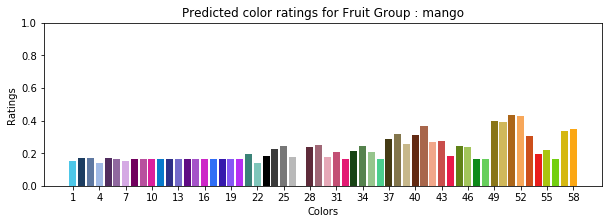

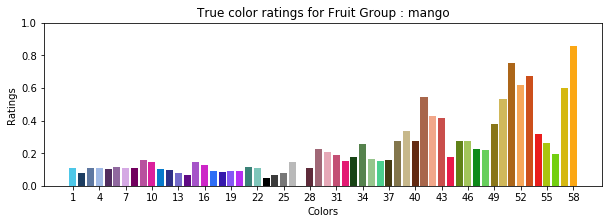

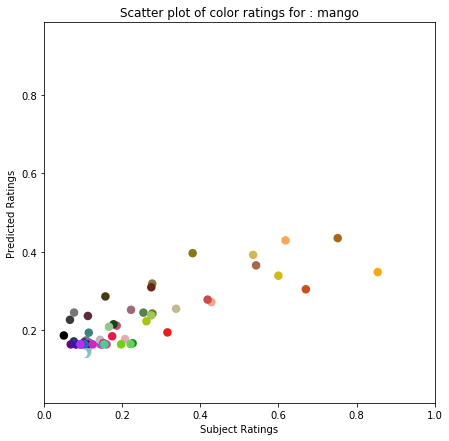

Score is : -0.11
Coefficients:  [ 0.15539566  0.3450513  -0.13963383  0.17091216]

Mean squared error: 0.0406
Variance score: -0.11
The true squared error (in color ratings) for left out fruit watermelon is: 2.2038

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2001
p-value 0.1321


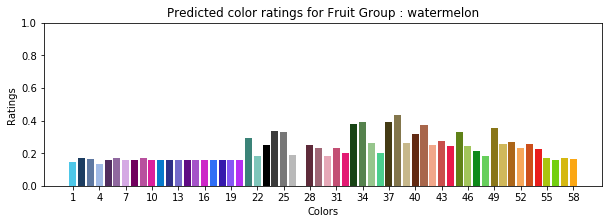

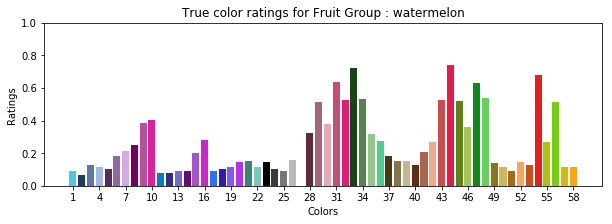

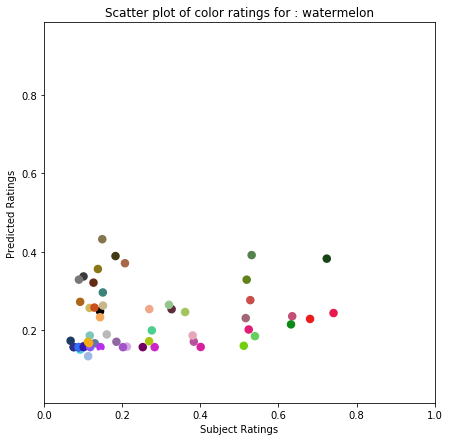

Score is : 0.46
Coefficients:  [ 0.16082989  0.32617085 -0.13751537  0.17731114]

Mean squared error: 0.0109
Variance score: 0.46
The true squared error (in color ratings) for left out fruit honeydew is: 0.5065

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7556
p-value 0.0000


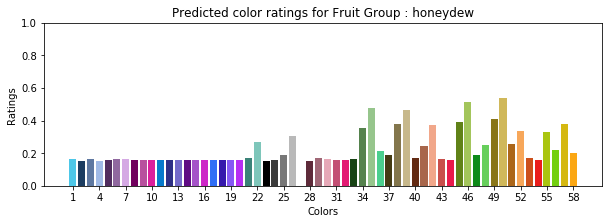

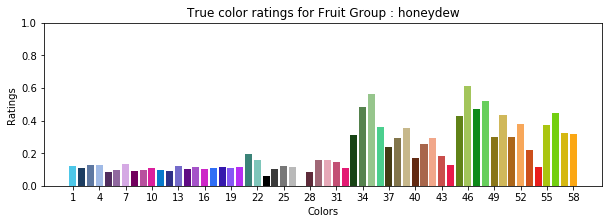

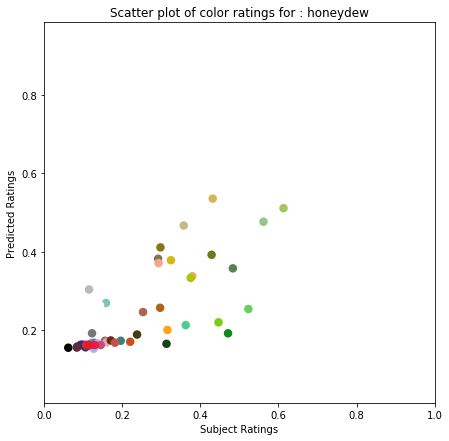

Score is : 0.52
Coefficients:  [ 0.16127595  0.32131902 -0.11937698  0.15535034]

Mean squared error: 0.0151
Variance score: 0.52
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.7116

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8421
p-value 0.0000


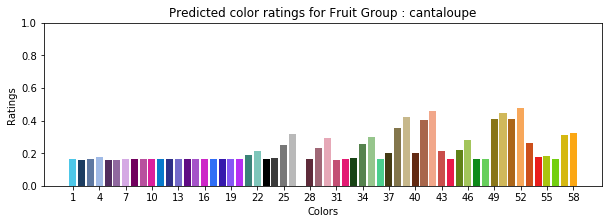

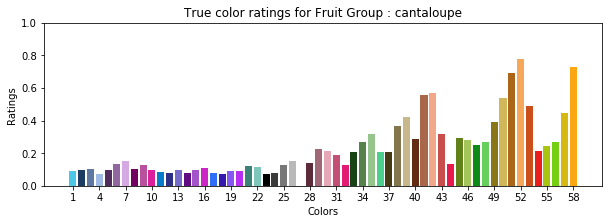

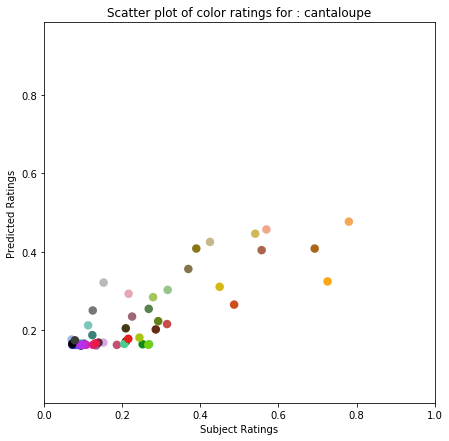

Score is : 0.51
Coefficients:  [ 0.16019813  0.30660661 -0.13666234  0.18139714]

Mean squared error: 0.0120
Variance score: 0.51
The true squared error (in color ratings) for left out fruit grapefruit is: 0.6028

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8342
p-value 0.0000


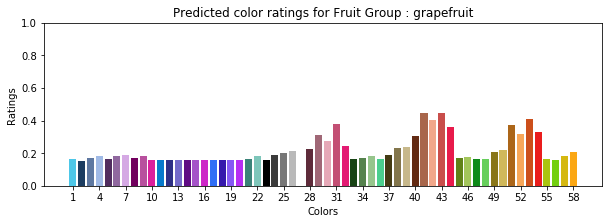

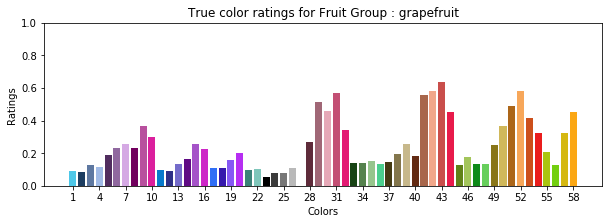

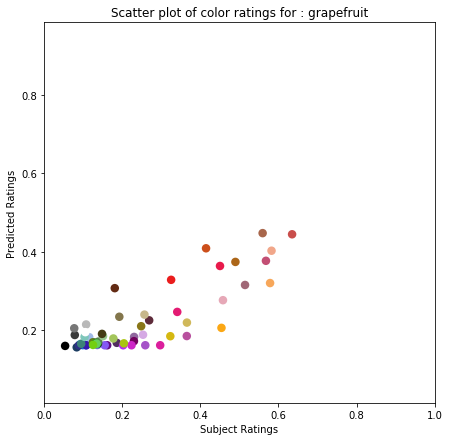

Score is : 0.27
Coefficients:  [ 0.15938494  0.30775635 -0.14256971  0.19353048]

Mean squared error: 0.0198
Variance score: 0.27
The true squared error (in color ratings) for left out fruit strawberry is: 1.0999

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5641
p-value 0.0000


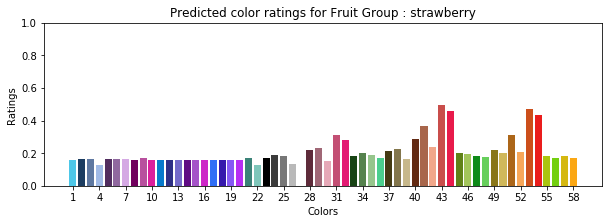

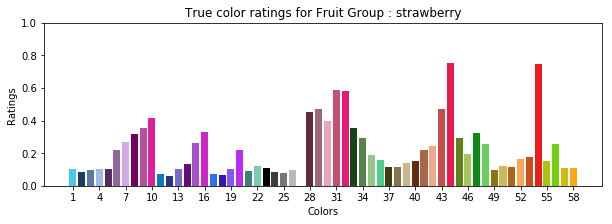

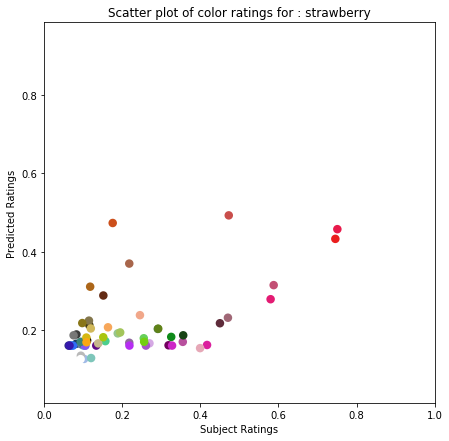

Score is : 0.18
Coefficients:  [ 0.1589297   0.33834631 -0.14341603  0.17371271]

Mean squared error: 0.0196
Variance score: 0.18
The true squared error (in color ratings) for left out fruit raspberry is: 0.9940

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5361
p-value 0.0000


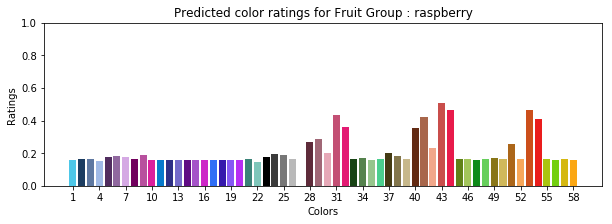

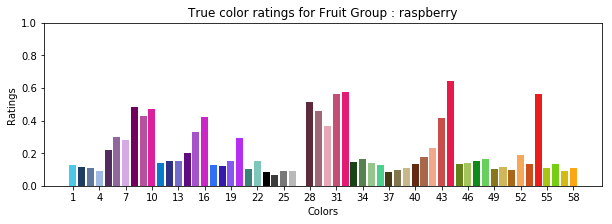

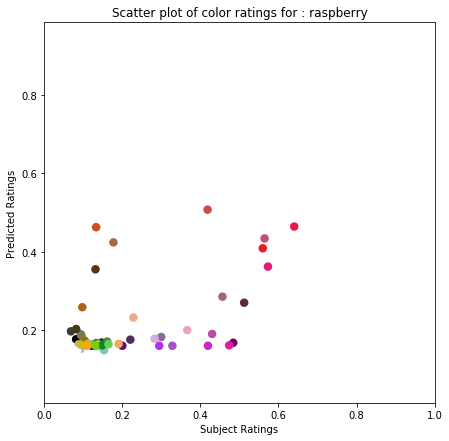

Score is : -0.05
Coefficients:  [ 0.15783113  0.31610318 -0.15017725  0.21620482]

Mean squared error: 0.0447
Variance score: -0.05
The true squared error (in color ratings) for left out fruit blueberry is: 2.4846

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2646
p-value 0.0447


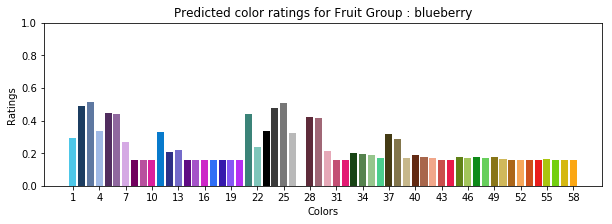

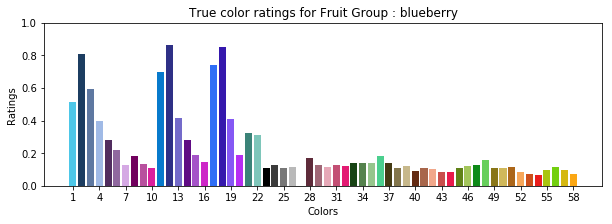

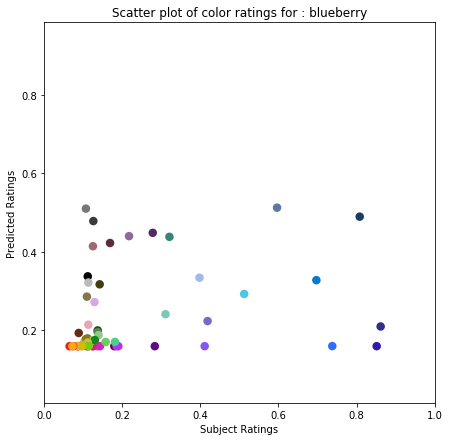

Score is : 0.18
Coefficients:  [ 0.16402004  0.3512884  -0.14195401  0.15128005]

Mean squared error: 0.0294
Variance score: 0.18
The true squared error (in color ratings) for left out fruit avocado is: 1.6419

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4926
p-value 0.0001


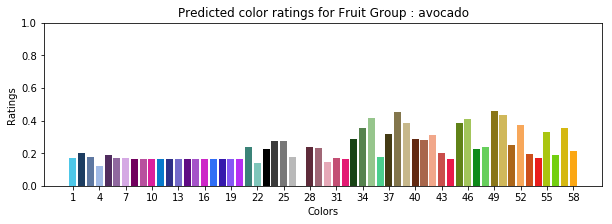

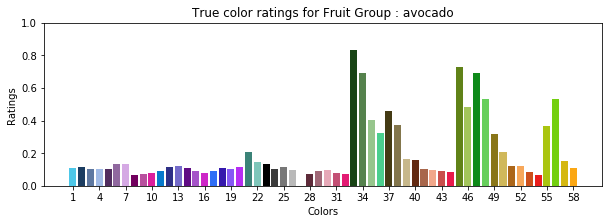

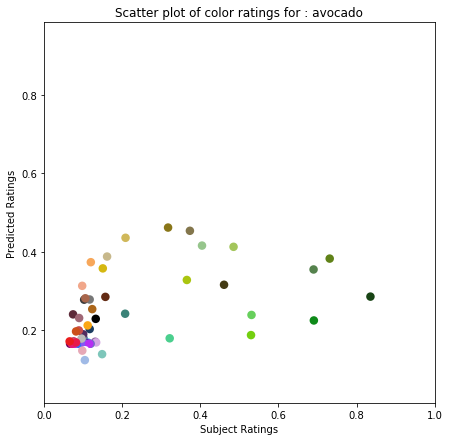

Score is : 0.54
Coefficients:  [ 0.16417051  0.30072686 -0.14016007  0.17455529]

Mean squared error: 0.0170
Variance score: 0.54
The true squared error (in color ratings) for left out fruit orange is: 0.8850

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9383
p-value 0.0000


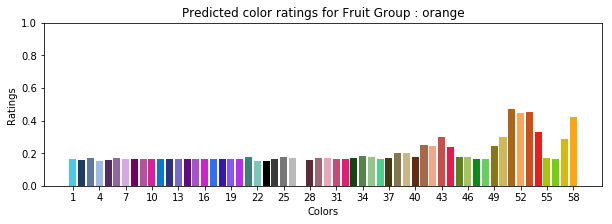

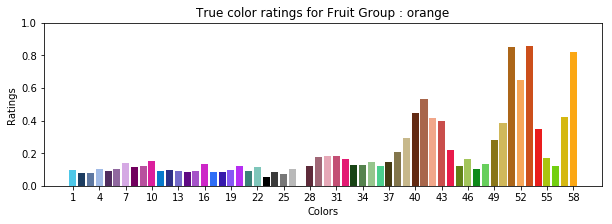

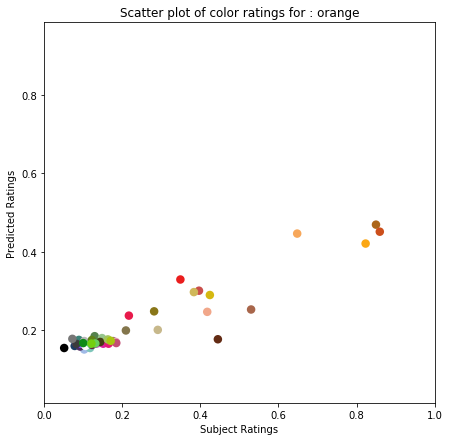

Score is : 0.26
Coefficients:  [ 0.16410877  0.30736004 -0.14971864  0.19107943]

Mean squared error: 0.0326
Variance score: 0.26
The true squared error (in color ratings) for left out fruit lime is: 1.6879

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6816
p-value 0.0000


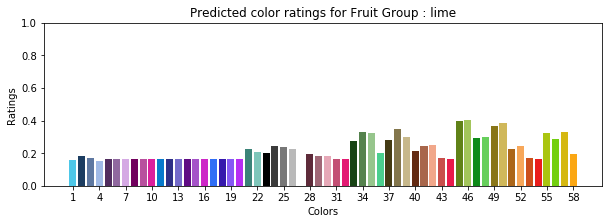

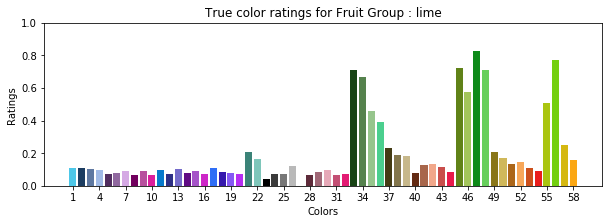

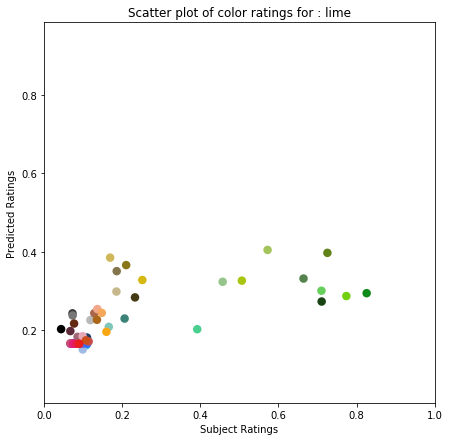

Score is : 0.39
Coefficients:  [ 0.16358621  0.28501618 -0.14046391  0.21004126]

Mean squared error: 0.0158
Variance score: 0.39
The true squared error (in color ratings) for left out fruit lemon is: 0.6924

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8699
p-value 0.0000


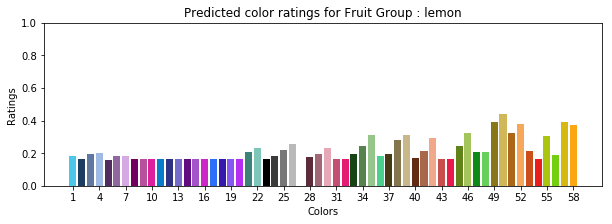

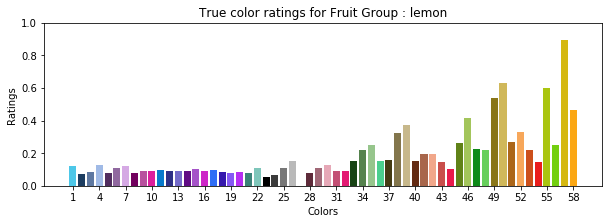

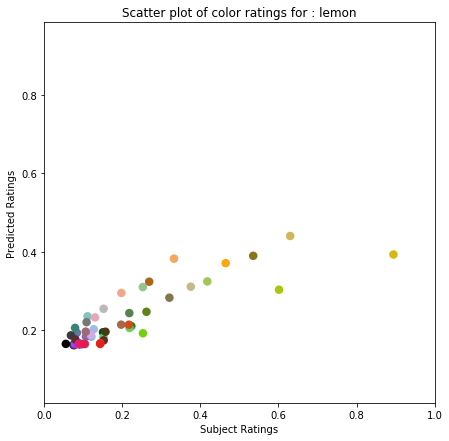

In [9]:
# Sparse features from Analysis I
minErrFeature1 = (4, 24, 29)
errSph, corrSph, win0_m1, win1_m1, win2_m1  = getRatings(minErrFeature1)

In [10]:
errSph

[0.9231913419612235,
 2.203750781383225,
 0.5064921183869759,
 0.7115853675342156,
 0.6028485675783457,
 1.099867525195477,
 0.9939887581166917,
 2.4845635225499367,
 1.641862489018587,
 0.8850143094857461,
 1.6878863912297768,
 0.6923648629297432]

In [11]:
corrSph

[0.8411272885750498,
 0.20006305967747087,
 0.7556370849287194,
 0.8421311964025101,
 0.8342284474430244,
 0.5640866272463915,
 0.5361394302501465,
 0.26463786118081073,
 0.4925988327353978,
 0.9383026523590384,
 0.6816234018527008,
 0.8698659042162058]

# Regression on top 3 spherical + cyindrical features

Score is : 0.65
Coefficients:  [0.13347408 0.11333402 0.10454374 0.22972521]

Mean squared error: 0.0117
Variance score: 0.65
The true squared error (in color ratings) for left out fruit mango is: 0.6064

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9016
p-value 0.0000


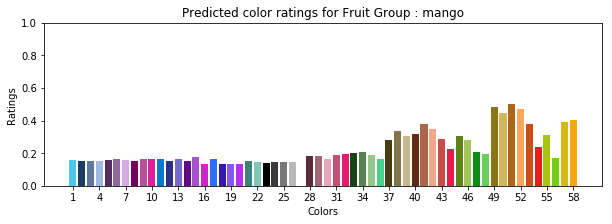

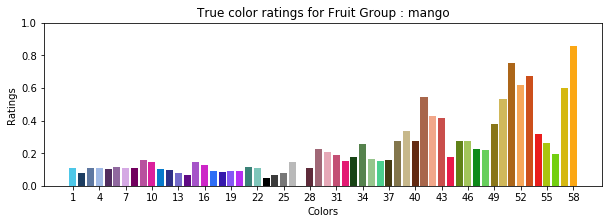

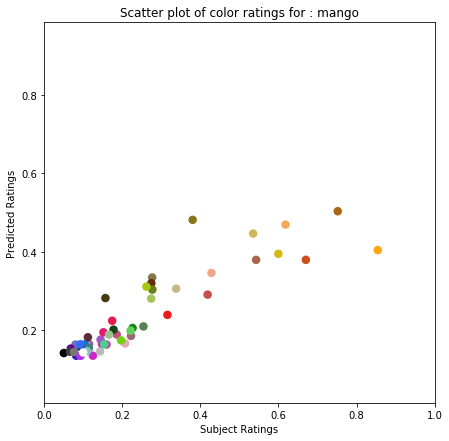

Score is : 0.02
Coefficients:  [0.12607902 0.17232614 0.1071958  0.19004938]

Mean squared error: 0.0361
Variance score: 0.02
The true squared error (in color ratings) for left out fruit watermelon is: 1.9509

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.3641
p-value 0.0050


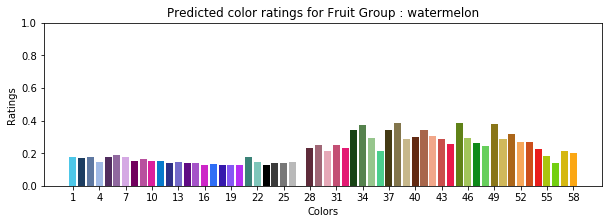

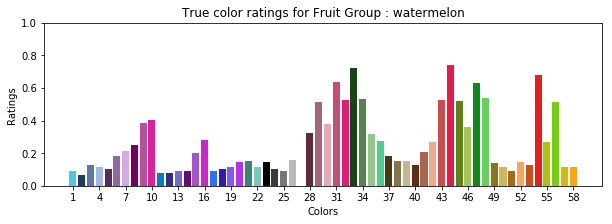

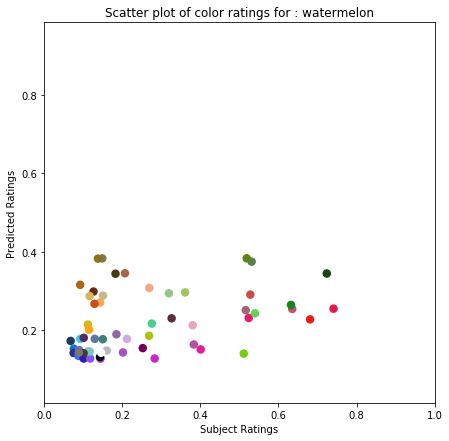

Score is : 0.59
Coefficients:  [0.13061105 0.11006365 0.17394438 0.19774513]

Mean squared error: 0.0082
Variance score: 0.59
The true squared error (in color ratings) for left out fruit honeydew is: 0.3948

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8158
p-value 0.0000


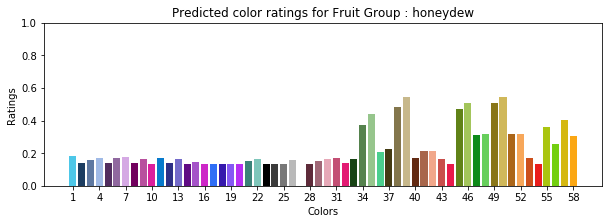

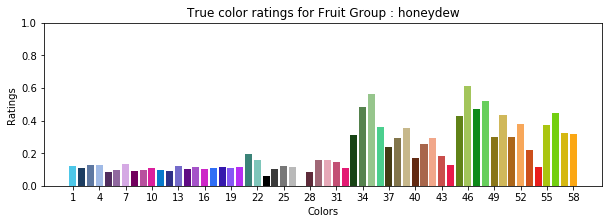

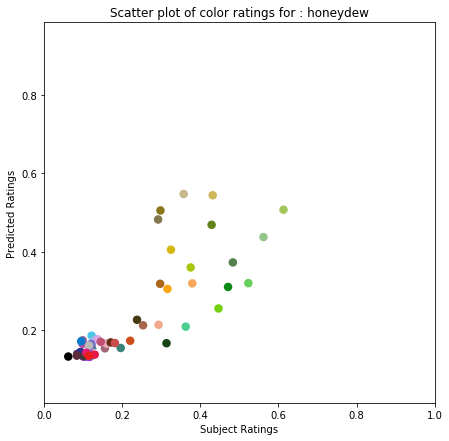

Score is : 0.62
Coefficients:  [0.1320096  0.14781427 0.13888597 0.17353143]

Mean squared error: 0.0118
Variance score: 0.62
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.5397

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8849
p-value 0.0000


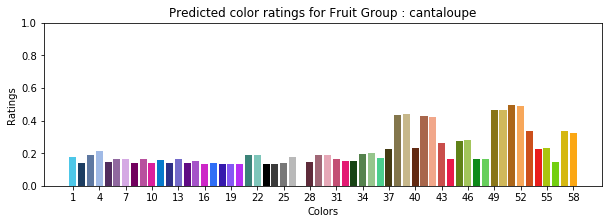

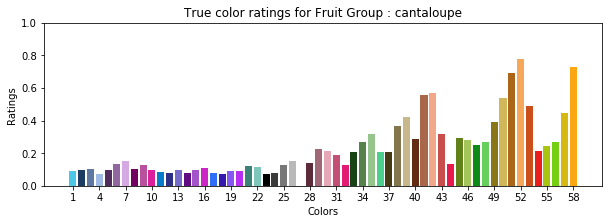

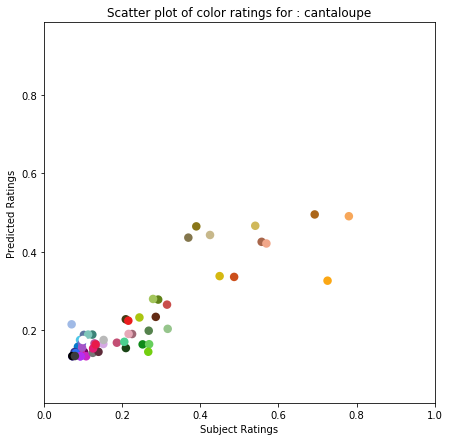

Score is : 0.59
Coefficients:  [0.13050069 0.10228206 0.16648692 0.20409314]

Mean squared error: 0.0099
Variance score: 0.59
The true squared error (in color ratings) for left out fruit grapefruit is: 0.4587

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8385
p-value 0.0000


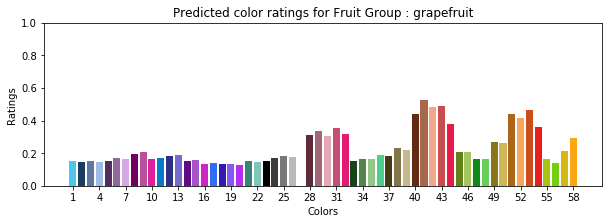

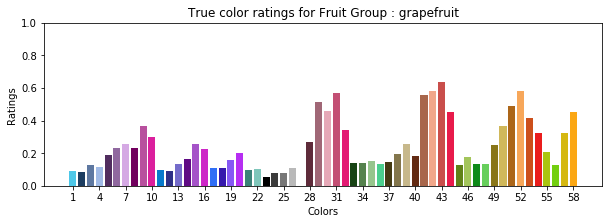

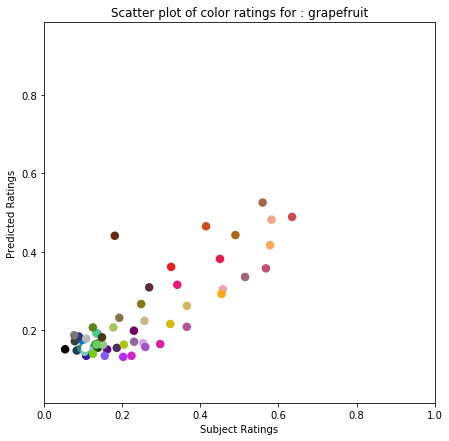

Score is : 0.27
Coefficients:  [0.12977704 0.13778669 0.11547373 0.21804952]

Mean squared error: 0.0200
Variance score: 0.27
The true squared error (in color ratings) for left out fruit strawberry is: 1.1094

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5561
p-value 0.0000


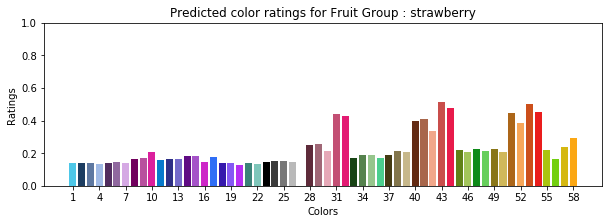

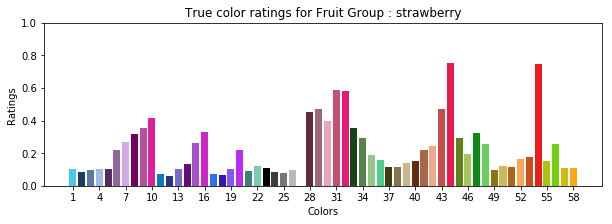

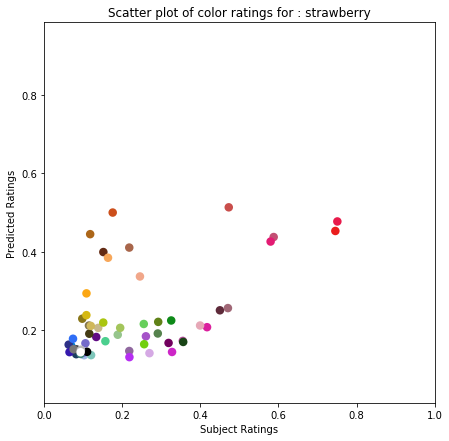

Score is : 0.17
Coefficients:  [0.12839859 0.15314829 0.11820924 0.21079558]

Mean squared error: 0.0197
Variance score: 0.17
The true squared error (in color ratings) for left out fruit raspberry is: 1.0088

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5731
p-value 0.0000


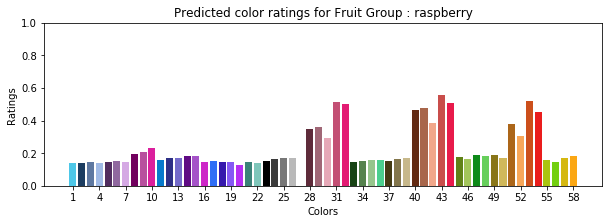

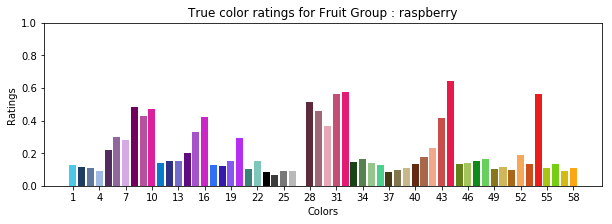

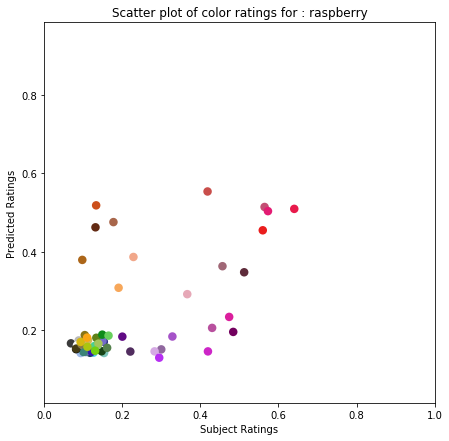

Score is : 0.23
Coefficients:  [0.12732631 0.12341418 0.13613639 0.20751639]

Mean squared error: 0.0329
Variance score: 0.23
The true squared error (in color ratings) for left out fruit blueberry is: 1.8316

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6066
p-value 0.0000


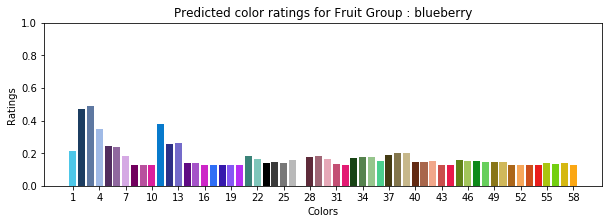

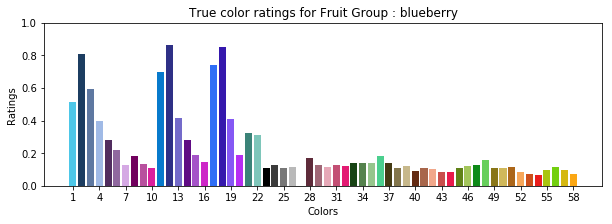

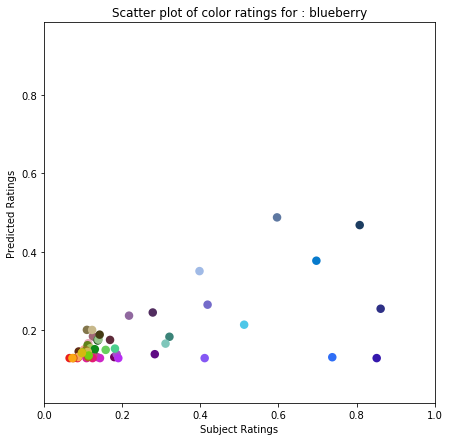

Score is : 0.32
Coefficients:  [0.13361465 0.17225478 0.14131308 0.15543337]

Mean squared error: 0.0245
Variance score: 0.32
The true squared error (in color ratings) for left out fruit avocado is: 1.3607

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6071
p-value 0.0000


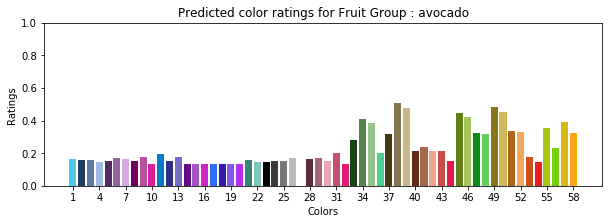

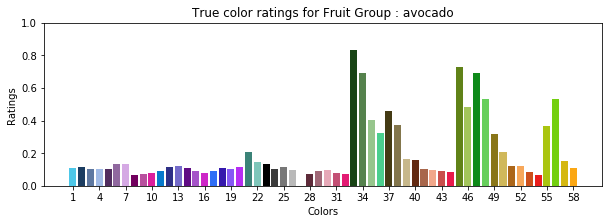

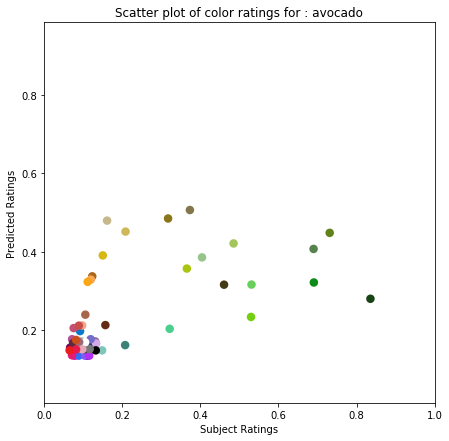

Score is : 0.64
Coefficients:  [0.13395508 0.164482   0.08154101 0.20027827]

Mean squared error: 0.0133
Variance score: 0.64
The true squared error (in color ratings) for left out fruit orange is: 0.6438

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8763
p-value 0.0000


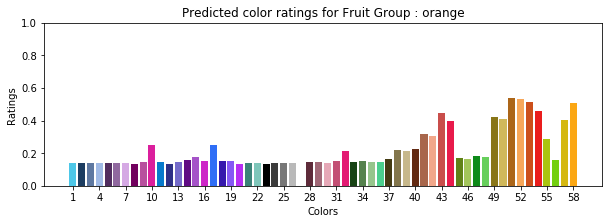

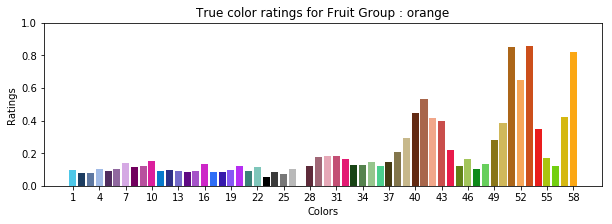

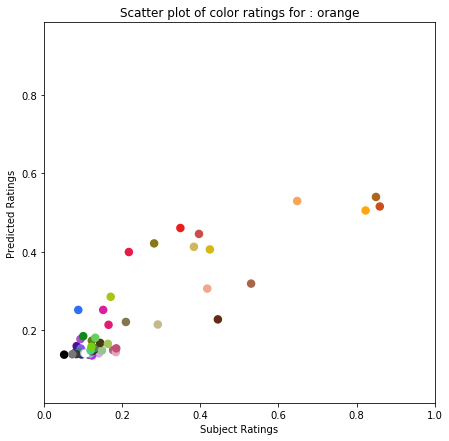

Score is : 0.35
Coefficients:  [0.13294194 0.12167296 0.10293478 0.23688782]

Mean squared error: 0.0285
Variance score: 0.35
The true squared error (in color ratings) for left out fruit lime is: 1.4108

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7065
p-value 0.0000


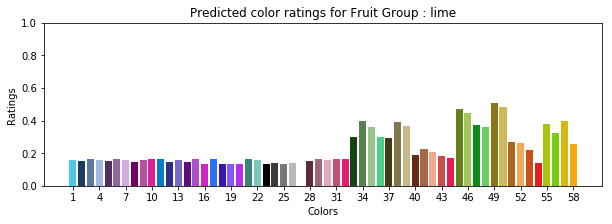

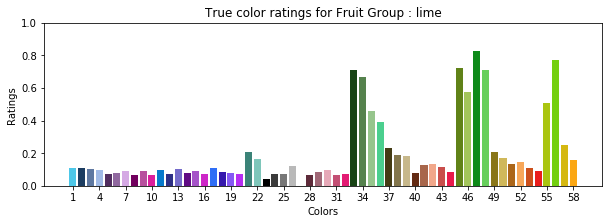

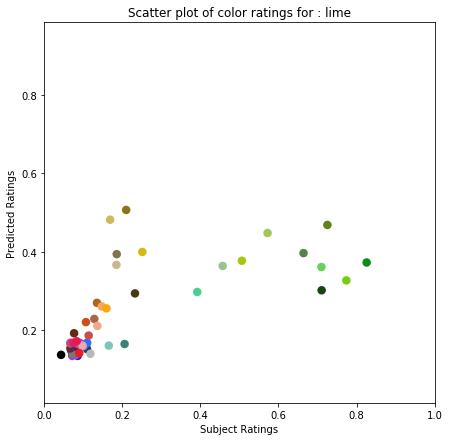

Score is : 0.53
Coefficients:  [0.1335833  0.13615794 0.11143498 0.21461374]

Mean squared error: 0.0123
Variance score: 0.53
The true squared error (in color ratings) for left out fruit lemon is: 0.4753

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8918
p-value 0.0000


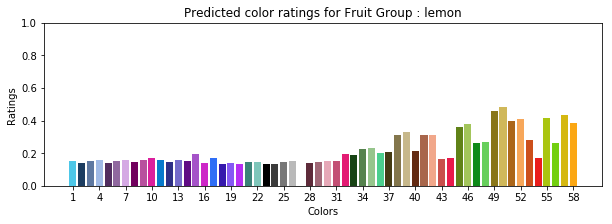

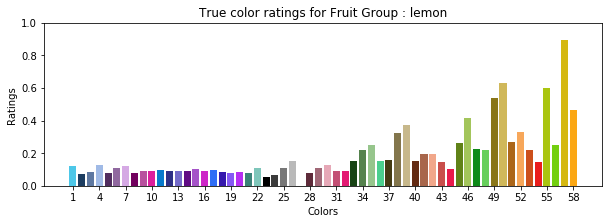

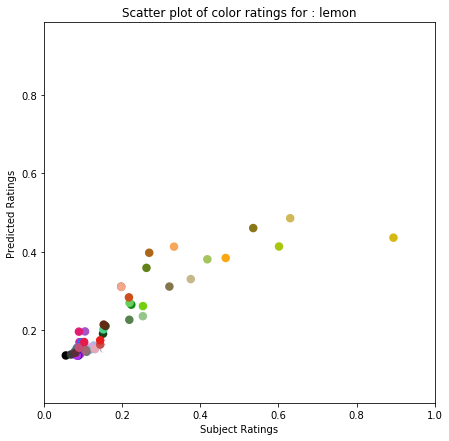

In [12]:
# Sparse features from Analysis II
minErrFeature2 = (54, 78, 179)
errSphCyl, corrSphCyl,win0_m2, win1_m2, win2_m2 = getRatings(minErrFeature2)

# Regression on top 3 Spherical + Cylindrical + Categorical

Score is : 0.61
Coefficients:  [0.12810696 0.02720255 0.22910467 0.38553089]

Mean squared error: 0.0130
Variance score: 0.61
The true squared error (in color ratings) for left out fruit mango is: 0.6014

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9061
p-value 0.0000


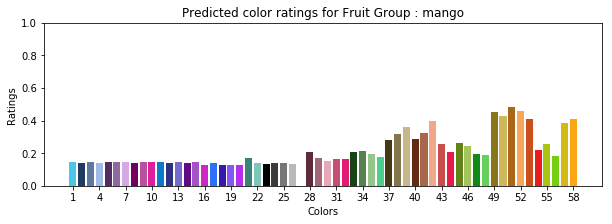

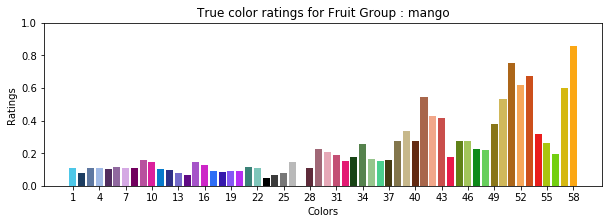

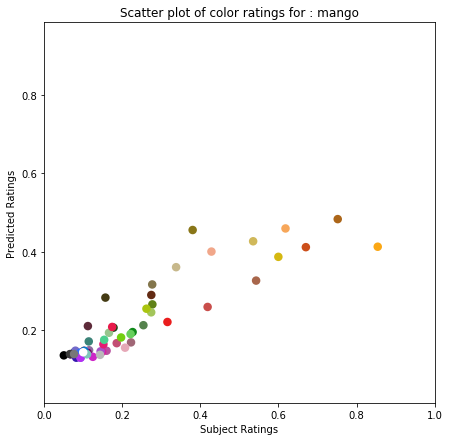

Score is : 0.16
Coefficients:  [0.12238635 0.08567278 0.19816195 0.37520198]

Mean squared error: 0.0307
Variance score: 0.16
The true squared error (in color ratings) for left out fruit watermelon is: 1.5506

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5415
p-value 0.0000


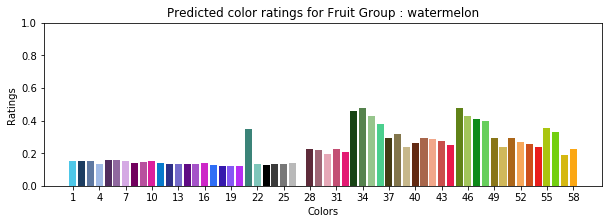

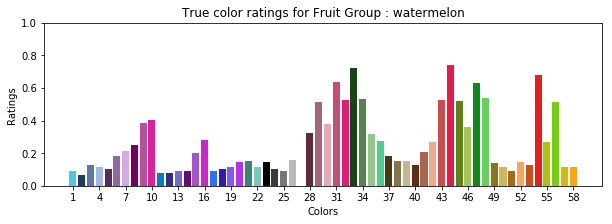

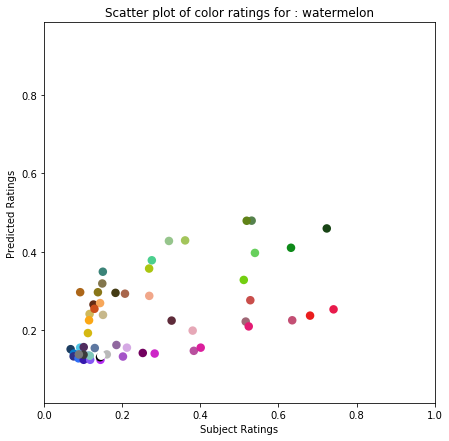

Score is : 0.75
Coefficients:  [0.12670993 0.06790197 0.20985453 0.37792444]

Mean squared error: 0.0051
Variance score: 0.75
The true squared error (in color ratings) for left out fruit honeydew is: 0.2029

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9128
p-value 0.0000


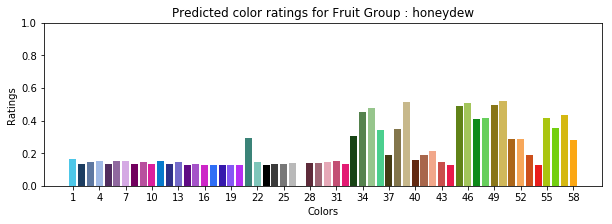

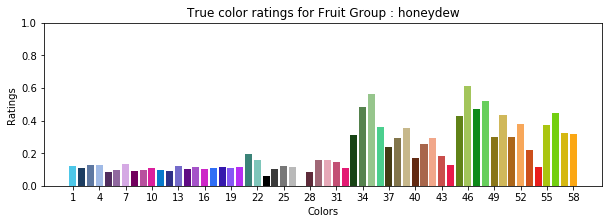

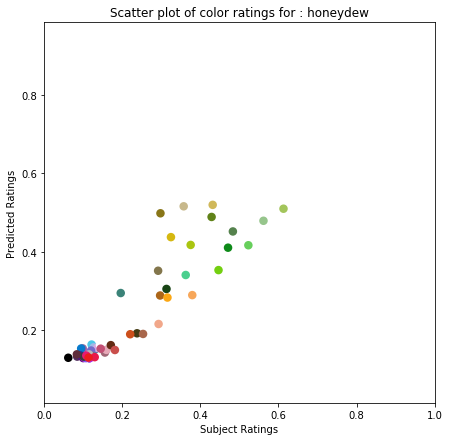

Score is : 0.68
Coefficients:  [0.12702987 0.08735553 0.17608431 0.37801421]

Mean squared error: 0.0100
Variance score: 0.68
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.4101

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9353
p-value 0.0000


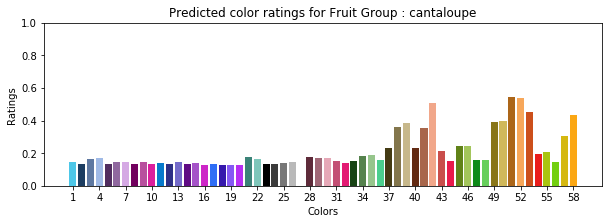

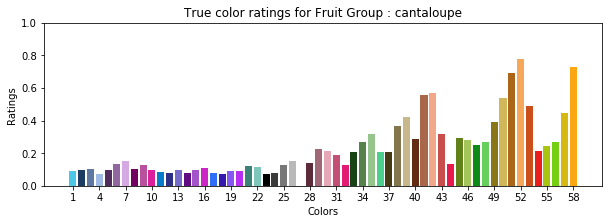

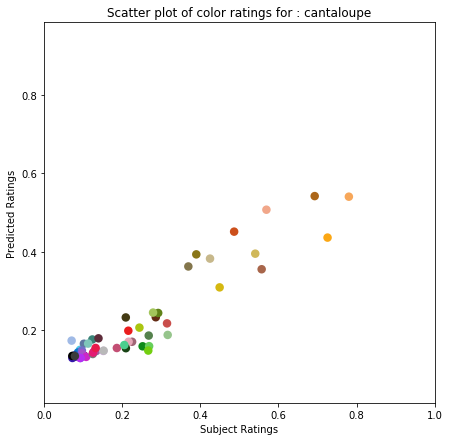

Score is : 0.55
Coefficients:  [0.12517744 0.04191293 0.22070154 0.38932188]

Mean squared error: 0.0111
Variance score: 0.55
The true squared error (in color ratings) for left out fruit grapefruit is: 0.4949

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8509
p-value 0.0000


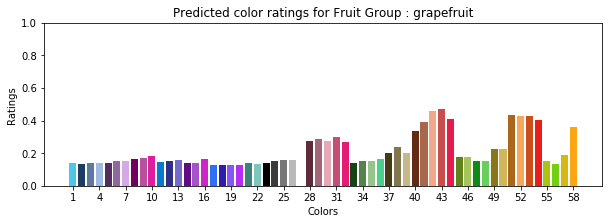

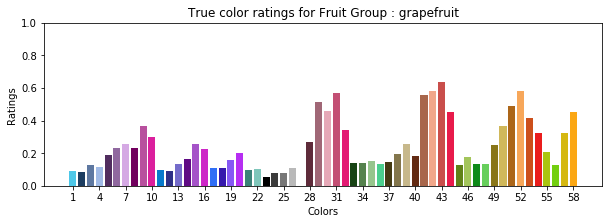

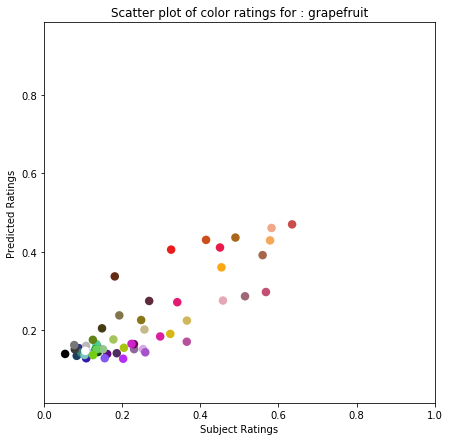

Score is : 0.41
Coefficients:  [0.12464943 0.06368027 0.21969449 0.36787728]

Mean squared error: 0.0160
Variance score: 0.41
The true squared error (in color ratings) for left out fruit strawberry is: 0.8746

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6717
p-value 0.0000


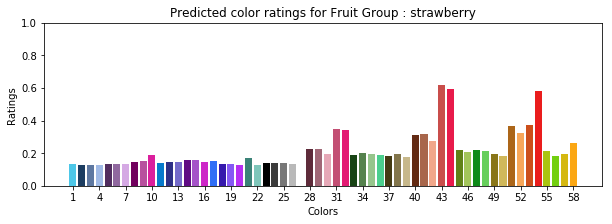

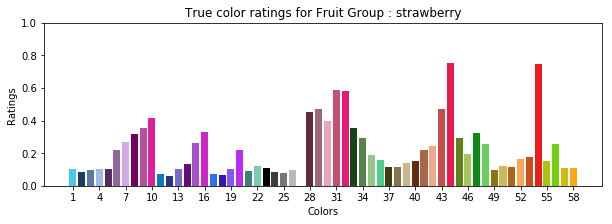

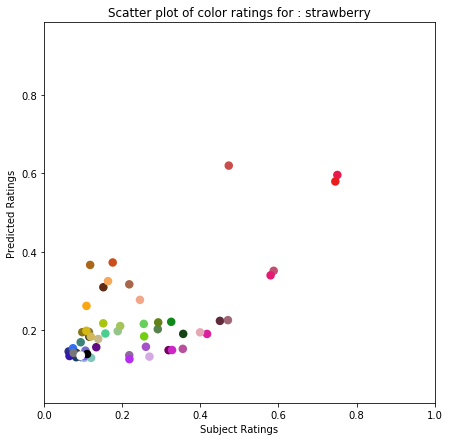

Score is : 0.30
Coefficients:  [0.12321982 0.07695405 0.21206134 0.37412853]

Mean squared error: 0.0166
Variance score: 0.30
The true squared error (in color ratings) for left out fruit raspberry is: 0.8425

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6452
p-value 0.0000


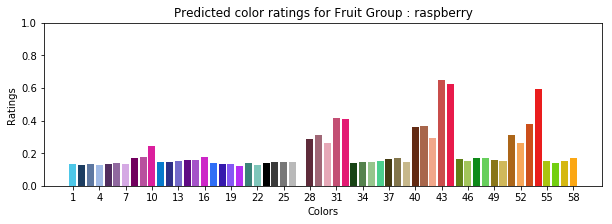

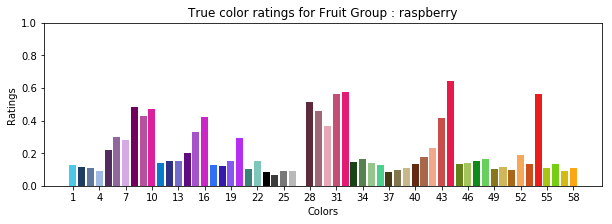

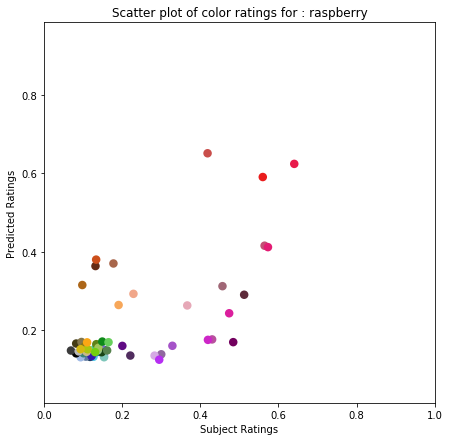

Score is : 0.65
Coefficients:  [0.12637697 0.0781659  0.21222506 0.33848283]

Mean squared error: 0.0148
Variance score: 0.65
The true squared error (in color ratings) for left out fruit blueberry is: 0.7672

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8605
p-value 0.0000


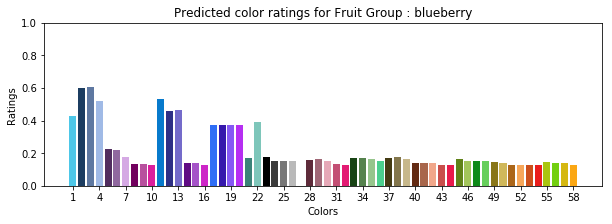

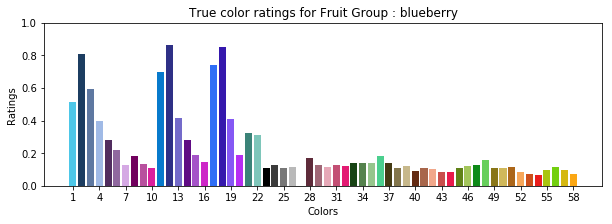

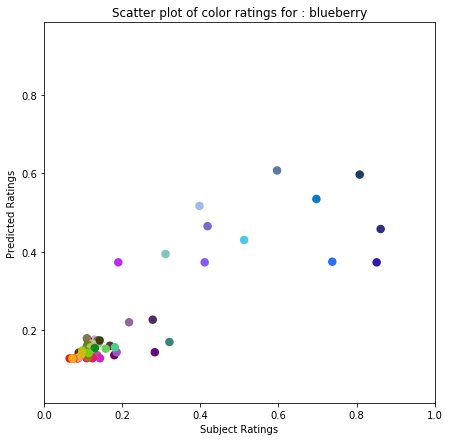

Score is : 0.43
Coefficients:  [0.12930945 0.1089613  0.16894304 0.36569779]

Mean squared error: 0.0203
Variance score: 0.43
The true squared error (in color ratings) for left out fruit avocado is: 1.1008

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7109
p-value 0.0000


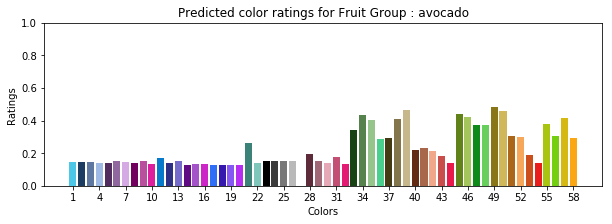

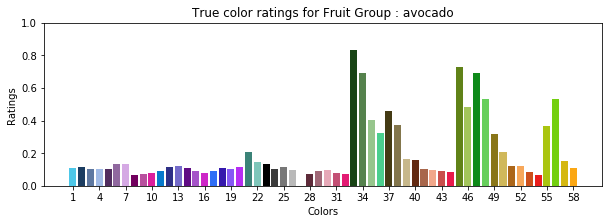

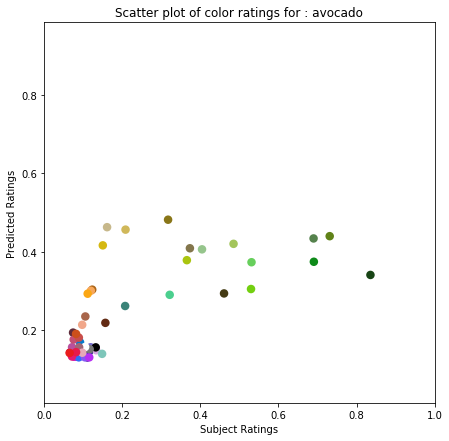

Score is : 0.73
Coefficients:  [0.12833933 0.06330871 0.20512417 0.37377371]

Mean squared error: 0.0099
Variance score: 0.73
The true squared error (in color ratings) for left out fruit orange is: 0.4118

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9231
p-value 0.0000


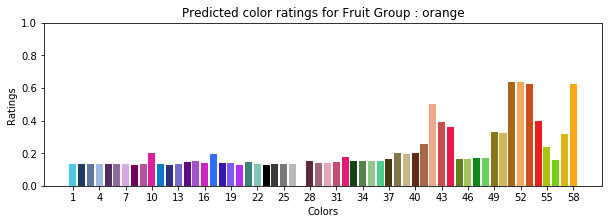

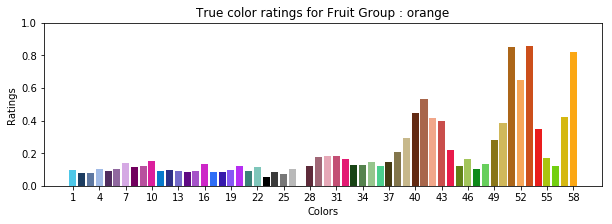

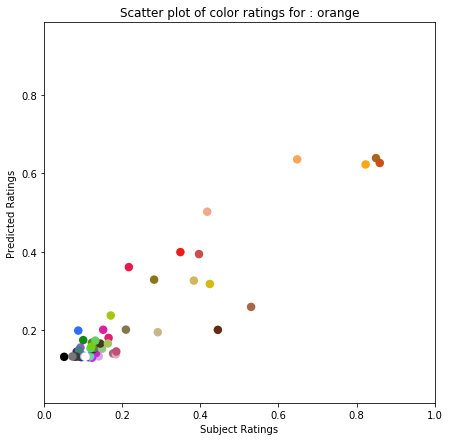

Score is : 0.54
Coefficients:  [0.1281239  0.03202361 0.25492902 0.36716915]

Mean squared error: 0.0200
Variance score: 0.54
The true squared error (in color ratings) for left out fruit lime is: 0.7309

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8901
p-value 0.0000


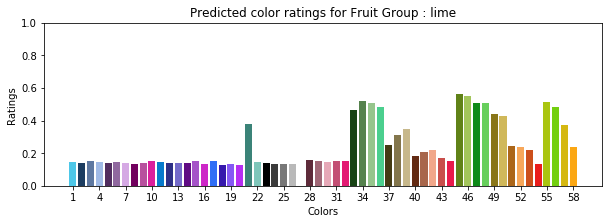

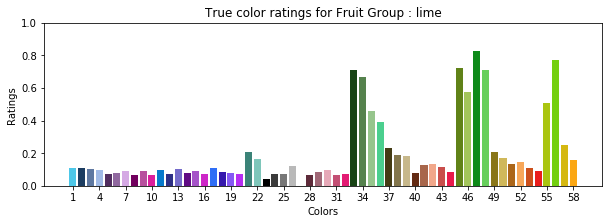

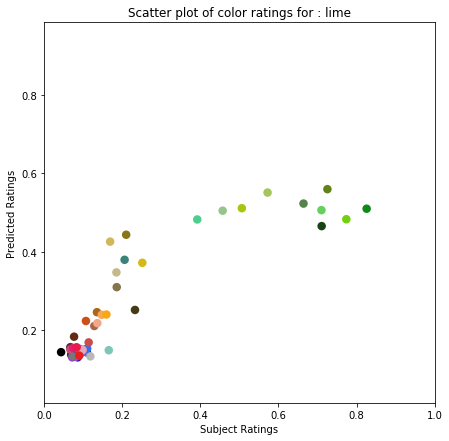

Score is : 0.45
Coefficients:  [0.12810182 0.04278984 0.22596637 0.39232651]

Mean squared error: 0.0143
Variance score: 0.45
The true squared error (in color ratings) for left out fruit lemon is: 0.4172

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9003
p-value 0.0000


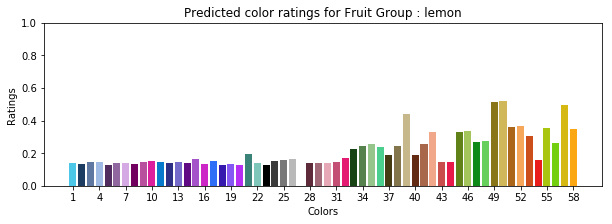

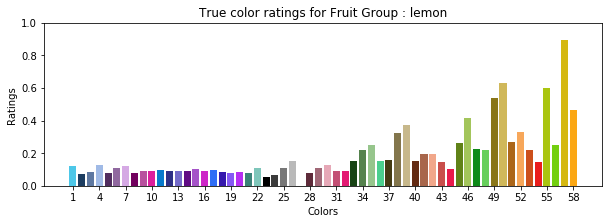

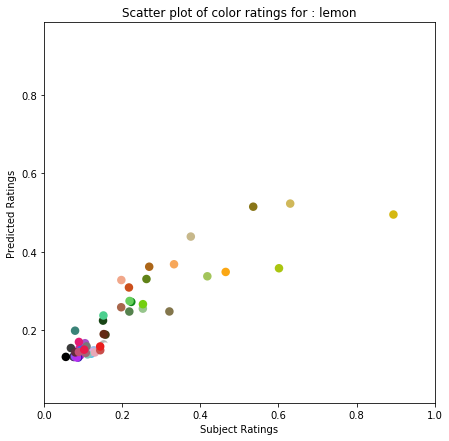

In [13]:
# Sparse features from Analysis III
minErrFeature3 = (54, 179, 180)
errSphCylCat, corrSphCylCat, win0_m3, win1_m3, win2_m3 = getRatings(minErrFeature3)

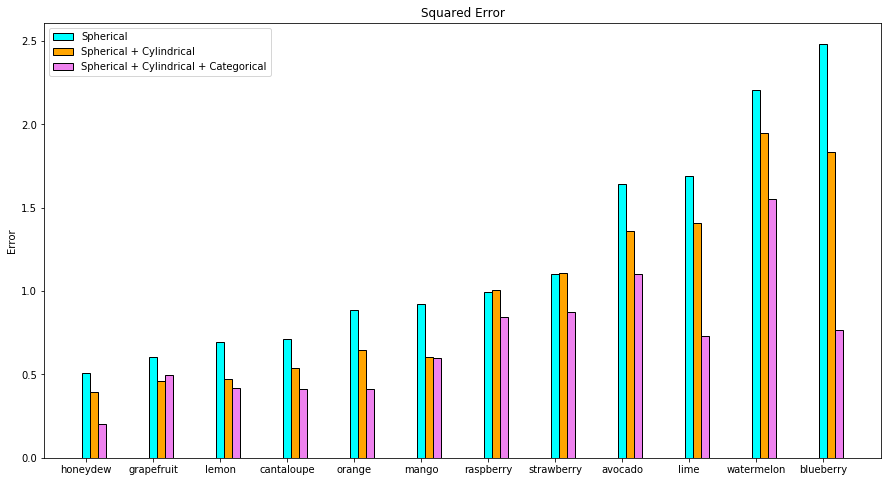

In [14]:
temp  = errSph
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(errSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[errSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[errSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Squared Error")
plt.ylabel('Error')
plt.legend()
#plt.savefig('ErrWithIncreasingRadial.pdf')
plt.show()

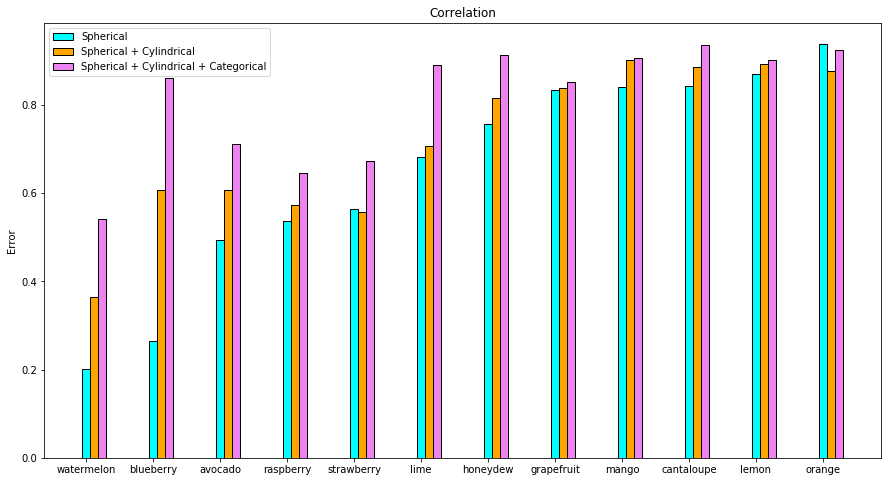

In [15]:
temp  = corrSph
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.close('all')
#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(corrSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[corrSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[corrSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Correlation")
plt.ylabel('Error')
plt.legend()
#plt.savefig('CorrWithIncreasingRadial.eps')
plt.show()

In [16]:
# # For plots of correlations
# err, corr, win0, win1, win2 = getRatings(minErrFeature3, True)

# Figure2: Scatter plots for the best model

In [17]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,model_num):
    print("----------------------- Creating plots for Model ---------------",model_num)
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')

    plt.subplots(3,4,figsize=(10,10))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        if k == 1 or k == 5 or k == 9:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    #plotName = "ScatterPlot_Model_"+str(model_num)+".pdf"
    #plt.savefig(plotName)
    plt.show()
    
    

----------------------- Creating plots for Model --------------- 1


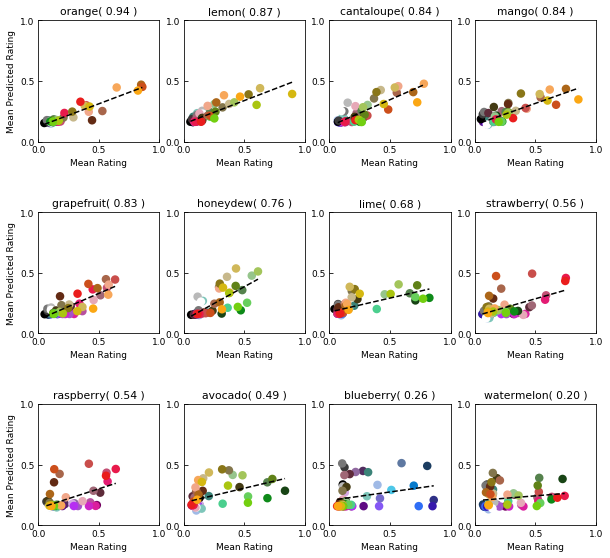

----------------------- Creating plots for Model --------------- 2


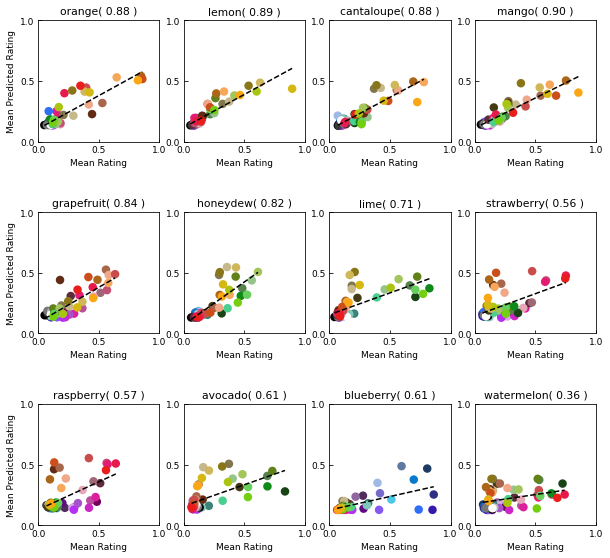

----------------------- Creating plots for Model --------------- 3


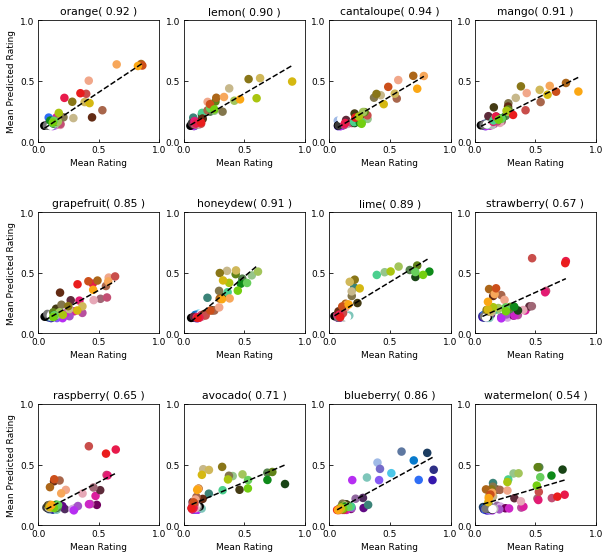

In [18]:
indices = np.argsort(win0_m1) # Want in the order of model 1 correlations
createScatterPlots(indices, win0_m1, win1_m1, win2_m1,1)
createScatterPlots(indices, win0_m2, win1_m2, win2_m2,2)
createScatterPlots(indices,win0_m3, win1_m3, win2_m3,3)

In [19]:
# indices = np.argsort(win0_m3)
# print(indices)
# print(win0_m3)

In [20]:
# k = 1
# plt.close('all')
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 9})
# plt.subplots(3,4,figsize=(10,10))
# for i in range(len(indices)-1,-1,-1):
#     # Scatter plot
    
#     arg = indices[i]
#     trueRating = win1_m3[arg]
#     avg_pred = win2_m3[arg]
    
#     ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
#     #ax = f.add_subplot(3,4,k)
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
#     if k == 1 or k == 5 or k == 9:
#         plt.ylabel('Mean Predicted Rating')
#     plt.xlabel('Mean Rating')
#     s = allConcepts[arg]+"( %.2f )" %win0_m3[arg]
#     #print(s)
#     plt.title(s)
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.yticks([0,0.5,1])
#     plt.xticks([0,0.5,1])
#     plt.tick_params(direction='in')
#     plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
#     k = k+1
# #plt.savefig('ScatterPlotBestModel.pdf')
# plt.show()

In [21]:
cor_m3,_ = stats.pearsonr(np.array(win2_m3).flatten(), np.array(win1_m3).flatten())
cor_m2,_ = stats.pearsonr(np.array(win2_m2).flatten(), np.array(win1_m2).flatten())
cor_m1,_ = stats.pearsonr(np.array(win2_m1).flatten(), np.array(win1_m1).flatten())

In [22]:
print("For PHOTO 5")
print("model 1:", cor_m1)
print("model 2:",cor_m2)
print("model :3",cor_m3)

For PHOTO 5
model 1: 0.6098095604571551
model 2: 0.6958426874174599
model :3 0.8026204870386462


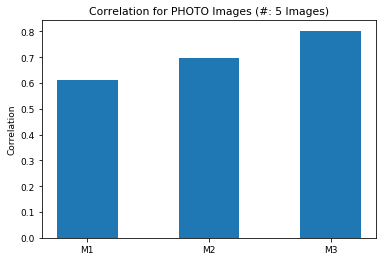

In [23]:
barWidth = 0.5
plt.bar(range(1,4),[cor_m1, cor_m2, cor_m3], width = barWidth)
plt.xticks(range(1,4),['M1','M2','M3'])
plt.title("Correlation for PHOTO Images (#: 5 Images)")
plt.ylabel('Correlation')
plt.show()

In [24]:
import numpy as np
np.array([[3, 5, 6],[5, 6, 7]]).dot(np.array([1, 1,2]))

array([20, 25])

In [27]:
print(win2_m3)

[[0.14306080324136639, 0.14139332595929438, 0.14438179459326625, 0.13778435080061718, 0.1460888692423718, 0.1474911157477859, 0.1430118249847438, 0.14132677156435602, 0.14614120965349287, 0.14362961715176056, 0.14561009267186348, 0.14142160953766808, 0.14631159956924766, 0.13691564482988236, 0.14467844610891298, 0.13059594111953007, 0.14136250979131226, 0.12837350017971838, 0.12838746784757563, 0.12837350017971838, 0.17000653256311665, 0.1372286485528651, 0.13435206279121434, 0.13764118099962777, 0.13765616613890702, 0.13562852564684666, 0.14229417707145875, 0.20931277783063895, 0.1676007904256523, 0.15401191634201603, 0.16556238847130067, 0.16270896747583374, 0.20536769149068998, 0.21155462503175934, 0.19220413484352078, 0.1741467569613581, 0.2822244131363224, 0.31589912448908203, 0.36012758573533005, 0.28894487370985134, 0.32577000120917676, 0.4000751065652026, 0.25831805829342885, 0.2071366906580141, 0.2648731862043041, 0.2445277786094436, 0.19398654998760664, 0.18889452516839808, 0